# Blood glucose prediction

[Data description](https://www.sciencedirect.com/science/article/pii/S2352340924005262#bib0005)

[Paper](https://www.mdpi.com/1424-8220/21/21/7090)


**Aim of project**: Predict glucose values 1h in advance (with special focus on hyper-/hypoglycemia)

# Setup
Download the data from the published repository and load the preprocessed data in pandas

In [ ]:
import os
data_folder = 'AdvancedTimeSeriesCourse-Engineering-Data/Data'
if not os.path.exists(data_folder):
  !git clone https://github.com/ChristopherKunze-Git/AdvancedTimeSeriesCourse-Engineering-Data

Cloning into 'AdvancedTimeSeriesCourse-Engineering-Data'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 193 (delta 53), reused 18 (delta 6), pack-reused 83 (from 1)
Receiving objects: 100% (193/193), 55.45 MiB | 6.77 MiB/s, done.
Resolving deltas: 100% (88/88), done.
Updating files: 100% (31/31), done.


In [ ]:
from pathlib import Path
import glob
import os
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima.model import ARIMA

from scipy import stats
from scipy.stats import zscore

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

In [ ]:
def add_time_features(df, time_id='time'):
    df['day_of_week'] = df[time_id].dt.dayofweek
    df['month'] = df[time_id].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['time_of_day'] = df[time_id].dt.hour + df[time_id].dt.minute / 60
    df['hour_sin'] = np.sin(2 * np.pi * df['time_of_day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['time_of_day'] / 24)
    return df

def calc_time_since_event(df, event_mask, freq=1, cap=np.inf):
    not_event = ~event_mask
    time_since_event = (not_event.groupby((not_event != not_event.shift()).cumsum())
                              .transform('cumsum'))
    time_since_event = time_since_event / freq
    time_since_event = time_since_event.where(time_since_event <= cap, cap)
    return time_since_event


def show_interactive_ts_plot(df, var_names = None, normalization="None", title="",
                             show_first_only=False, groups={}, layout=None):
    """
    input:
        df: pd.DataFrame
        var_names: list of column names
        normalization: 'None', 'MinMax', 'ZScore' - which normalization to apply
        hide_all: bool - if True, all traces will be hidden at first
    """
    if var_names is None:
        var_names = df.select_dtypes(include=['number']).columns.to_list()

    for k, col in enumerate(var_names):
        if normalization == 'MinMax':
            df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
        elif normalization == 'ZScore':
            df[col] = zscore(df[col])

    fig = go.Figure()
    for k, col in enumerate(var_names):
        if groups:
            group = next(key for key, val in groups.items() if col in val)
            first_group = next(iter(groups))
            visible = 'legendonly' if show_first_only and group!=first_group else True
            fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col, visible=visible,
                                     legendgroup=group, legendgrouptitle_text=group))
        else:
            visible = 'legendonly' if show_first_only and (k>0) else True
            fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col, visible=visible))
    fig.update_layout(
        title = title,
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1d",
                        step="day",
                        stepmode="backward"),
                    dict(count=7,
                        label="1w",
                        step="day",
                        stepmode="backward"),
                    dict(count=1,
                        label="1m",
                        step="month",
                        stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )
    if layout is not None:
        fig.update_layout(layout)

    fig.show()

In [ ]:
dfs = {}
for filename in Path(f'{data_folder}').glob('*.csv'):
    print(filename.stem)
    df = pd.read_csv(filename)
    df['time'] = pd.to_datetime(df['time'])
    if 'old_time' in df.columns:
        df['old_time'] = pd.to_datetime(df['old_time'])
    dfs[filename.stem] = df

dfs['train_p27_no_gaps'].head(1)

train_p27_no_gaps
test_multi_no_gaps
test_p27_no_gaps
test_multi
train_multi
test_p27
train_p27
train_multi_no_gaps


,time,old_time,subj,glucose,burned_calories,heart_rate,basal_insulin,bolus_insulin,hour_of_day,hour_sin,hour_cos,heart_rate_imp,glucose_imp
0,2020-06-26 22:15:00,2020-06-26 22:15:00,P27,112.0,22.655359,81.0,0.066,0.0,22,-0.5,0.866025,81.0,112.0


In [ ]:
dfs['train_multi_no_gaps_wp27'] = pd.concat([dfs['train_p27_no_gaps'], dfs['train_multi_no_gaps']])
dfs['test_multi_no_gaps_wp27'] = pd.concat([dfs['test_p27_no_gaps'], dfs['test_multi_no_gaps']])

# Modeling Blood sugar (SARIMAX)

In [ ]:
# data were sampled at 15min-intervals and linearly interpolated. So we can just model at 15min frequency instead
freq = '15min'
one_hour = pd.Timedelta('1h') // pd.Timedelta(freq)
one_day = pd.Timedelta('1d') // pd.Timedelta(freq)
one_week = 7*one_day

covariates = ['heart_rate_imp', 'basal_insulin', 'bolus_insulin', 'hour_sin',
              'hour_cos', 'day_of_week', 'is_weekend', 'time_of_day', 'time_since_meal']

def get_df(name, covariates=covariates):
    df = dfs[name].copy()
    add_time_features(df, time_id='old_time')
    df['time_since_meal'] = calc_time_since_event(df, df['bolus_insulin'] > 0,
                                                  freq=one_hour, cap=24)
    # use imputated data
    rename_map = {'glucose_imp': 'glucose', 'heart_rate_imp': 'heart_rate'}
    df = (df[['subj', 'time', 'glucose_imp', *covariates]]
              .groupby([pd.Grouper(key='time', freq=freq), 'subj']).first().reset_index(level=1)
              .rename(columns=rename_map))
    return df

df_train = get_df('train_p27_no_gaps')
#df_train = pd.concat(get_df(['train_multi_no_gaps'), get_df('train_p27_no_gaps')])
df_test = get_df('test_p27_no_gaps')
#df_test = get_df('test_multi_no_gaps')

In [ ]:
glucose = df_train['glucose']
glucose_delta = glucose.diff()[1:] #np.gradient(glucose)

## ADF, ACF & PACF

In [ ]:
# let's check if unit-roots for the glucose level (or its derivation) exist
print(f'ADF test(glucose): p-Value={sm.tsa.stattools.adfuller(glucose)[1]:.4f}')
print(f'ADF test(∆glucose): p-Value={sm.tsa.stattools.adfuller(glucose_delta)[1]:.4f}')

ADF test(glucose): p-Value=0.0000
ADF test(∆glucose): p-Value=0.0000


Based on the ADF test we reject the H0 hypothesis (existence of a unit-root). Next we check the ACF and PACF plots:

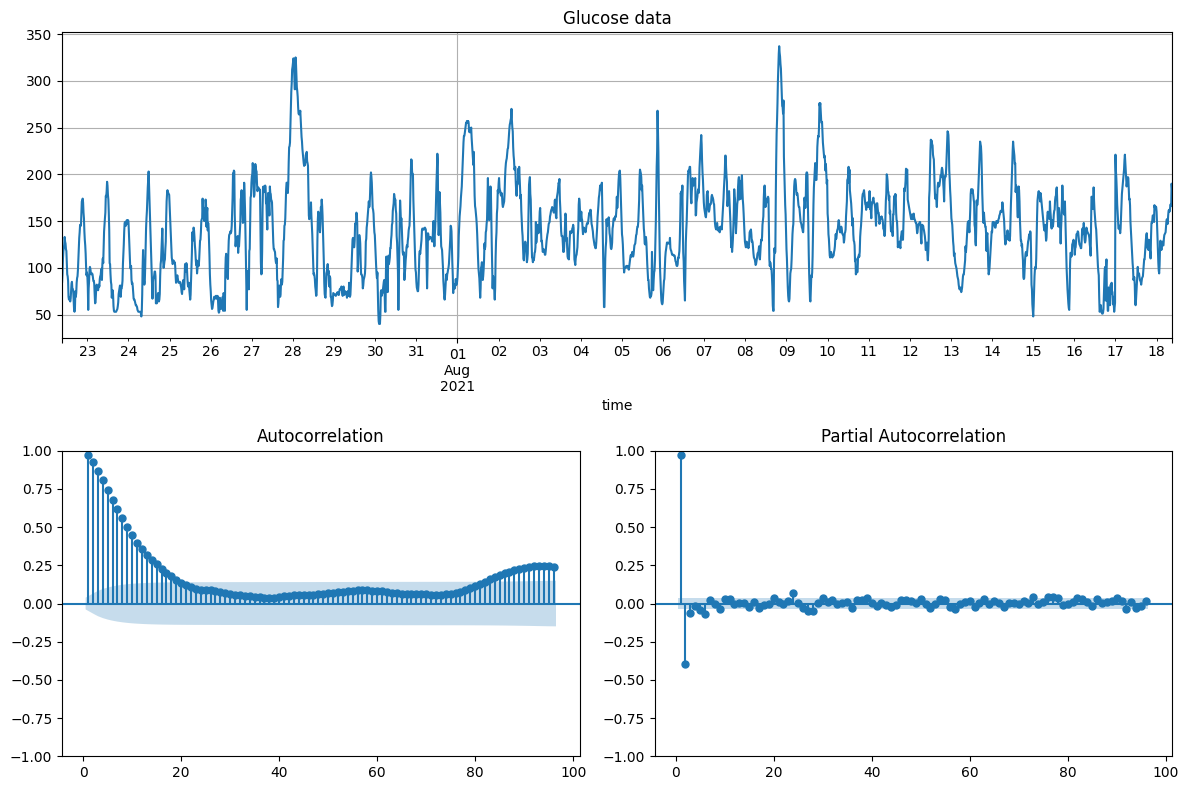

In [ ]:
# for a stationary signal 4 weeks of data should be enough
X = glucose.iloc[-4*one_week:].copy()
#X = glucose_delta.iloc[-4*one_week:-one_day].copy()

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
X.plot(grid=True)
plt.title('Glucose data')

ax = plt.subplot(2, 2, 3)
sm.graphics.tsa.plot_acf(X, zero=False, lags= one_day, ax=ax);

ax = plt.subplot(2, 2, 4)
sm.graphics.tsa.plot_pacf(X, zero=False, lags= one_day, ax=ax);

plt.tight_layout()
plt.show()

The autocorrelations are significant for a large number of lags - but perhaps the autocorrelations at higher lags are merely due to the propagation of earlier autocorrelations.

This is confirmed by the PACF plot: Note that the PACF plot has significant spikes at lag 1 and lag 2 and than a big drop, meaning that most of the higher-order autocorrelations are effectively explained by the lag-1 & lag-2 partial autocorrelation.



## ARIMA
Let's try to model the data with this order (2,0,0)

In [ ]:
X = df_train.iloc[-4*one_week:].copy()

In [ ]:
model = ARIMA(X['glucose'].values, order=(2,0,0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2688
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -10084.636
Date:                Tue, 18 Feb 2025   AIC                          20177.272
Time:                        21:59:40   BIC                          20200.858
Sample:                             0   HQIC                         20185.803
                               - 2688                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        139.1289      5.263     26.435      0.000     128.814     149.444
ar.L1          1.3640      0.008    170.606      0.000       1.348       1.380
ar.L2         -0.4032      0.008    -52.031      0.000      -0.418      -0.388
sigma2       106.1089      0.998    106.279      0.000     104.152     108.066
===================================================================================
Ljung-Box (L1) (Q):                   1.75   Jarque-Bera (JB):             58138.57
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             1.07
Prob(H) (two-sided):                  0.75   Kurtosis:                        25.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# We can also test some other orders, e.g. (2,0,1) or (3,0,0)
best_score = np.inf
best_order = None
best_arima_model = None
for order in [(2,0,0), (2,0,1), (3,0,0), (3,0,1), (2,1,0)]:
    model = ARIMA(X['glucose'].values, order=order).fit()
    if model.bic < best_score:
        best_score = model.bic
        best_order = order
        best_arima_model = model
print('Best order:', best_order)
print(best_arima_model.summary())

Best order: (2, 0, 1)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2688
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -10079.048
Date:                Fri, 28 Feb 2025   AIC                          20168.096
Time:                        18:54:28   BIC                          20197.579
Sample:                             0   HQIC                         20178.760
                               - 2688                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        139.1273      4.882     28.501      0.000     129.560     148.695
ar.L1          1.5011      0.034     44.337      0.000       1.435       1.567
ar.L2         -0.5365      0.0

Seems like an order (2,0,1) model is slightly better. Let's continue using that order and have a look at the residuals and the QQ-plot

Durbin-Watson: 1.9897519526752756
NormaltestResult(statistic=1041.7183043691603, pvalue=6.219340828863516e-227)


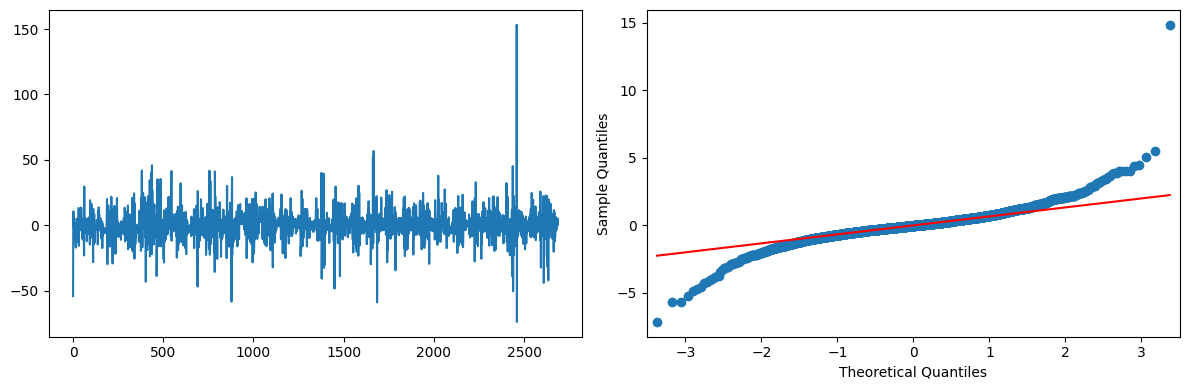

In [ ]:
# check residuals
resid = best_arima_model.resid
print('Durbin-Watson:', sm.stats.durbin_watson(resid))
print(stats.normaltest(resid))

fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ax = plt.plot(resid)
ax = plt.subplot(1,2,2)
fig = qqplot(resid, line='q', ax=ax, fit=True)
plt.tight_layout()
plt.show()

The model does a mediocre job. The residual plot shows some outliers and the QQ-plot has a bad fit at low and high quantiles. This propably means the model does not estimate the variance that well.

In [ ]:
import warnings
warnings.filterwarnings("ignore") # ignore the convergance warnings

# some helper methods
def rolling_forecast_eval(model, y, n_steps=1, refit=False):
    forecasts = []
    # Save initial forecast
    forecasts.extend(model.forecast(steps=n_steps))

    # Step through the rest of the sample
    for t in range(len(y) - n_steps):
        # Update the results by appending the next observation
        if refit:
            model = model.append(y.values[t:t+1], refit=True)
        else:
            model = model.extend(y.values[t:t+1])

        # Save the next forecast
        forecasts.append(model.forecast(steps=n_steps).iloc[-1])

    # Combine all forecasts into a Series
    forecasts = pd.Series(forecasts, index=y.index, name=y.name)
    scores = {
        'rmse': root_mean_squared_error(y[n_steps-1:], forecasts[n_steps-1:]),
        'mape': mean_absolute_percentage_error(y[n_steps-1:], forecasts[n_steps-1:]),
    }
    return forecasts, scores

def rolling_forecast_eval_exog(model, y, exog, n_steps=1, refit=False):
    forecasts = []
    # Save initial forecast
    forecasts.extend(model.forecast(steps=n_steps, exog=exog.iloc[:n_steps]))
    # Step through the rest of the sample
    for t in range(len(y) - n_steps):
        # Update the results by appending the next observation
        model = model.append(y.iloc[t:t+1], exog=exog.iloc[t:t+1], refit=refit)

        # Save the next forecast
        forecast = model.forecast(steps=n_steps, exog=exog.iloc[t+1:t+n_steps+1])
        forecasts.append(forecast.values[-1])

    # Combine all forecasts into a Series
    forecasts = pd.Series(forecasts, index=y.index, name=y.name)
    scores = {
        'rmse': root_mean_squared_error(y[n_steps-1:], forecasts[n_steps-1:]),
        'mape': mean_absolute_percentage_error(y[n_steps-1:], forecasts[n_steps-1:]),
    }
    return forecasts, scores


In [ ]:
glucose_pred, scores = rolling_forecast_eval(best_arima_model, df_test.glucose, one_hour)

print(pd.Series(scores).round(2))
show_interactive_ts_plot(pd.DataFrame({'actual': df_test.glucose, 'forecast': glucose_pred}), ['actual', 'forecast'])

In [ ]:
print(pd.Series(scores).round(2))
show_interactive_ts_plot(pd.DataFrame({'actual': df_test.glucose, 'forecast': glucose_pred}), ['actual', 'forecast'])

rmse    25.94
mape     0.17
dtype: float64


## SARIMA

In [ ]:
best_sarima_model = None
best_score = np.inf

for s_len in [6*one_hour, 12*one_hour, one_day]:
    model = ARIMA(X['glucose'].values, order=(2,0,1), seasonal_order=(1,0,0,s_len))
    model_fit = model.fit()
    if model_fit.bic < best_score:
        best_sarima_model = model_fit
        best_score = model_fit.bic

if best_sarima_model.bic < best_arima_model.bic:
    print(best_sarima_model.summary())
else:
    print("Seasonal component does not improve BIC")

Seasonal component does not improve BIC


In [ ]:
## we can check all configs to be sure we use the best order (aka AutoARIMA)
## but this can take a looong time...

X_small = glucose.iloc[-one_week:-one_day].copy()

best_model = None
best_score = np.inf
best_result = None

max_ar = 6
max_ma = 1
for p in range(max_ar):
    for q in range(max_ma):
        for d in [0,1]:
            for s_len in [12*one_hour, one_day]:
                model = ARIMA(X_small.values, order=(p,d,q), seasonal_order=(1,0,0,s_len))
                model_fit = model.fit()
                if model_fit.bic < best_score:
                    best_model = model_fit
                    best_score = model_fit.bic
                    best_result = model_fit.summary()

print(best_result)

#show_interactive_ts_plot(pd.DataFrame({'actual': y, 'forecast': forecasts}), ['actual', 'forecast'])

## ARIMAX / ARDL

Let's try to incorporate some exogenous features and see if this helps our prediction

In [ ]:
X_endog = X['glucose']
X_exog = X.drop(columns=['subj', 'glucose'])

arimax_model = ARIMA(X_endog, order=(2,0,1), exog=X_exog).fit()
print(arimax_model.summary())

                               SARIMAX Results                                
Dep. Variable:                glucose   No. Observations:                 2688
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -10097.250
Date:                Fri, 28 Feb 2025   AIC                          20222.500
Time:                        19:28:43   BIC                          20305.052
Sample:                    07-22-2021   HQIC                         20252.360
                         - 08-19-2021                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              87.1519     14.022      6.215      0.000      59.670     114.634
heart_rate          0.0466      0.022      2.111      0.035       0.003       0.090
basal_insulin    -180.7844     2

This results in a lot of non-significant parameters (which is not unexpected). We will reduce them so that only significant remain.

In [ ]:
arimax_exog_vars = ['day_of_week', 'time_of_day']
X_endog = X['glucose']
X_exog = X[arimax_exog_vars]

arimax_model = ARIMA(X_endog, order=(2,0,1), exog=X_exog).fit()
print(arimax_model.summary())

#show_interactive_ts_plot(pd.DataFrame({'actual': X_endog, 'forecast': arimax_model.predict()}), ['actual', 'forecast'])
#X_endog.plot()
#model_fit.predict(0, len(X_endog)-1).plot()

                               SARIMAX Results                                
Dep. Variable:                glucose   No. Observations:                 2688
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -10064.463
Date:                Fri, 28 Feb 2025   AIC                          20142.927
Time:                        19:28:49   BIC                          20184.203
Sample:                    07-22-2021   HQIC                         20157.857
                         - 08-19-2021                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         130.6451      5.241     24.928      0.000     120.373     140.917
day_of_week     3.1711      0.297     10.687      0.000       2.590       3.753
time_of_day    -0.1683      0.052     -3.239    

In [ ]:
y_endog = df_test.glucose
y_exog = df_test[arimax_exog_vars]

glucose_pred, scores = rolling_forecast_eval_exog(arimax_model, y_endog, y_exog, one_hour)

print(scores)
show_interactive_ts_plot(pd.DataFrame({'actual': y_endog, 'forecast': glucose_pred}), ['actual', 'forecast'])

{'rmse': 26.017756902643324, 'mape': 0.17331992967254786}


Since there may be a time delay between the level of the exogenous features and their effect on glucose, we can also try to incorporate lags of them into the model

In [ ]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

ardl_exog_vars = ['basal_insulin', 'day_of_week', 'time_of_day',]
             # 'bolus_insulin', 'heart_rate']
X_exog = X[ardl_exog_vars]
X_endog = X.glucose

ardl_res = ardl_select_order(
    X_endog, 2, X_exog, one_hour, ic="bic", trend="c", causal=False
)
print(f"The optimal order is: {ardl_res.model.ardl_order}")
ardl_model = ardl_res.model.fit()
ardl_model.summary()

The optimal order is: (2, 4, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                glucose   No. Observations:                 2688
Model:                  ARDL(2, 4, 1)   Log Likelihood              -10038.395
Method:               Conditional MLE   S.D. of innovations             10.159
Date:                Fri, 28 Feb 2025   AIC                          20098.789
Time:                        19:28:49   BIC                          20163.643
Sample:                    07-22-2021   HQIC                         20122.248
                         - 08-19-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.9332      0.729      8.143      0.000       4.504       7.362
glucose.L1           1.3695      0.018     78.183      0.000       1.335       1.404
glucose.L2          -0.4090      0.018    -23.344      0.000      -0.443      -0.375
basal_insulin.L0   -22.0786     36.020     -0.613      0.540     -92.709      48.552
basal_insulin.L1    51.9452     49.078      1.058      0.290     -44.289     148.179
basal_insulin.L2  -132.4149     49.539     -2.673      0.008    -229.554     -35.276
basal_insulin.L3   316.6599     50.042      6.328      0.000     218.535     414.785
basal_insulin.L4  -220.8721     36.194     -6.103      0.000    -291.843    -149.902
day_of_week.L0       2.6579      0.692      3.839      0.000       1.300       4.015
day_of_week.L1      -2.7470      0.693     -3.967      0.000      -4.105      -1.389
====================================================================================
"""

In [ ]:
y_endog = df_test.glucose
y_exog = df_test[ardl_exog_vars]

glucose_pred, scores = rolling_forecast_eval_exog(ardl_model, y_endog, y_exog,
                                                  one_hour, refit=True)

print(scores)
show_interactive_ts_plot(pd.DataFrame({'actual': y_endog, 'forecast': glucose_pred}), ['actual', 'forecast'])

{'rmse': 25.877053681515118, 'mape': 0.16781721797238058}


## Eval all tasks

In [ ]:
def eval_tasks(model, train_key, test_key, exog_vars=None):
    df_train = get_df(train_key, covariates)
    df_test = get_df(test_key, covariates)
    if exog_vars is None:
        model = model.apply(df_train.glucose, refit=True)
        glucose_pred, scores = rolling_forecast_eval(model, df_test.glucose, one_hour)
    else:
        model = model.apply(df_train.glucose, df_train[exog_vars], refit=True)
        glucose_pred, scores = rolling_forecast_eval_exog(model, df_test.glucose,
                                                          df_test[exog_vars], one_hour)
    return glucose_pred, pd.Series(scores)

In [ ]:
#for name, model in {'ARIMA': best_arima_model, 'ARIMAX': arimax_model, 'ARDL': ardl_model}.items():
for name, model in {'ARIMA': best_arima_model}.items():
    print(f'Model: {name}')
    match(name):
        case 'ARIMA': exog_vars = None
        case 'ARIMAX': exog_vars = arimax_exog_vars
        case 'ARDL': exog_vars = ardl_exog_vars

    tasks = [('Task 1a', 'train_p27_no_gaps', 'test_p27_no_gaps'),
             ('Task 1b', 'train_multi_no_gaps_wp27', 'test_p27_no_gaps'),
             ('Task 2a', 'train_p27_no_gaps', 'test_multi_no_gaps'),
             ('Task 2b', 'train_multi_no_gaps_wp27', 'test_multi_no_gaps'),
             ]

    for task, train_key, test_key in tasks:
        print(f'{task}: {train_key} - {test_key}')
        glucose_pred, scores = eval_tasks(model, train_key, test_key, exog_vars)
        print(scores.round(2))

Model: ARIMA
Task 1a: train_p27_no_gaps - test_p27_no_gaps
rmse    25.86
mape     0.17
dtype: float64
Task 1b: train_multi_no_gaps_wp27 - test_p27_no_gaps
rmse    28.46
mape     0.19
dtype: float64
Task 2a: train_p27_no_gaps - test_multi_no_gaps
rmse    49.19
mape     0.27
dtype: float64
Task 2b: train_multi_no_gaps_wp27 - test_multi_no_gaps
rmse    47.06
mape     0.26
dtype: float64
